In [36]:
# Sorting Benchmark – Full Analysis Notebook
# Menggunakan data hasil pipeline (run_results.csv, variance_runs.csv)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import json, time, tracemalloc, gc
from itertools import product

# memastikan folder results ada
Path("../results").mkdir(exist_ok=True)

plt.style.use("seaborn-v0_8")

In [37]:
ROOT = Path.cwd().resolve()
while ROOT != ROOT.parent and not (ROOT / "src" / "run.py").exists():
    ROOT = ROOT.parent

SRC = ROOT / "src"
RESULTS_DIR = ROOT / "results"
DATA_DIR = ROOT / "data"

RESULTS_DIR.mkdir(exist_ok=True)

if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

import run 

algo_A, algo_B, algo_C, evaluate = run.algo_A, run.algo_B, run.algo_C, run.evaluate

In [38]:
df = pd.read_csv("../results/run_results.csv")
df_var = pd.read_csv("../results/variance_runs.csv")
df.head()

,instance,n,error,algo,time_ms,gap
0,sorting_near_sorted_1.json,1000,0.02,A,0.50,0.0
1,sorting_near_sorted_1.json,1000,0.02,B,0.63,0.0
2,sorting_near_sorted_1.json,1000,0.02,C,0.06,0.0
3,sorting_near_sorted_10.json,100000,0.02,A,73.33,0.0
4,sorting_near_sorted_10.json,100000,0.02,B,84.87,0.0


In [39]:
df_var.head()

,instance,n,error,algo,run_id,time_ms
0,sorting_near_sorted_3.json,1000,0.1,A,1,0.55
1,sorting_near_sorted_3.json,1000,0.1,A,2,0.51
2,sorting_near_sorted_3.json,1000,0.1,A,3,0.50
3,sorting_near_sorted_3.json,1000,0.1,A,4,0.53
4,sorting_near_sorted_3.json,1000,0.1,A,5,0.51


In [40]:
summary = df.groupby(["algo", "n"]).agg(
    mean_time=("time_ms", "mean"),
    sd_time=("time_ms", "std")
).reset_index()

summary

,algo,n,mean_time,sd_time
0,A,1000,0.523333,0.020817
1,A,5000,2.923333,0.083267
2,A,20000,12.893333,0.640338
3,A,100000,81.876667,14.278243
4,A,500000,428.276667,9.946690
5,B,1000,0.606667,0.025166
6,B,5000,3.303333,0.102632
7,B,20000,14.260000,0.225167
8,B,100000,95.650000,11.722815
9,B,500000,467.716667,2.885452


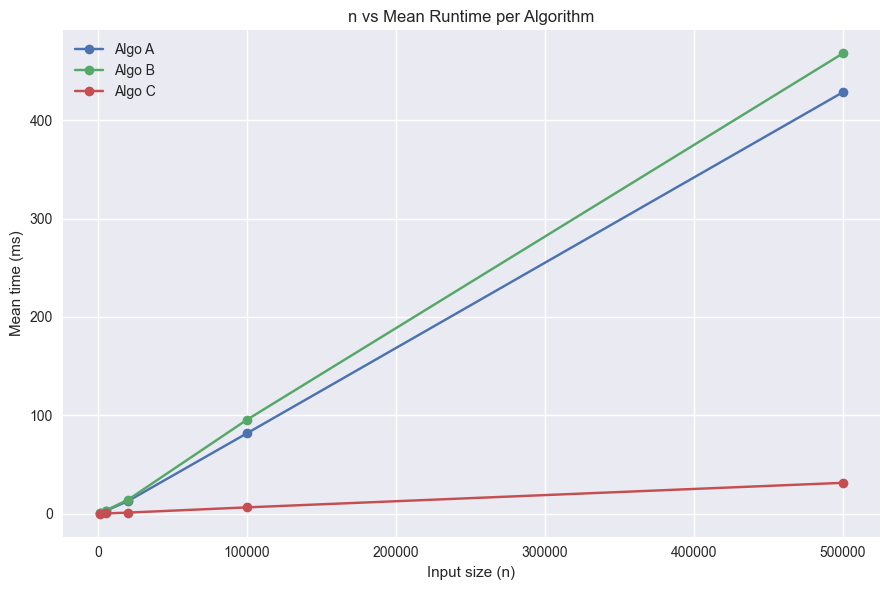

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

In [41]:
plt.figure(figsize=(9,6))

algos = sorted(summary['algo'].unique())  # ['A','B','C']

for algo in algos:
    xs = summary[summary['algo']==algo]['n']
    ys = summary[summary['algo']==algo]['mean_time']
    plt.plot(xs, ys, marker='o', label=f"Algo {algo}")

plt.xlabel("Input size (n)")
plt.ylabel("Mean time (ms)")
plt.title("n vs Mean Runtime per Algorithm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure()


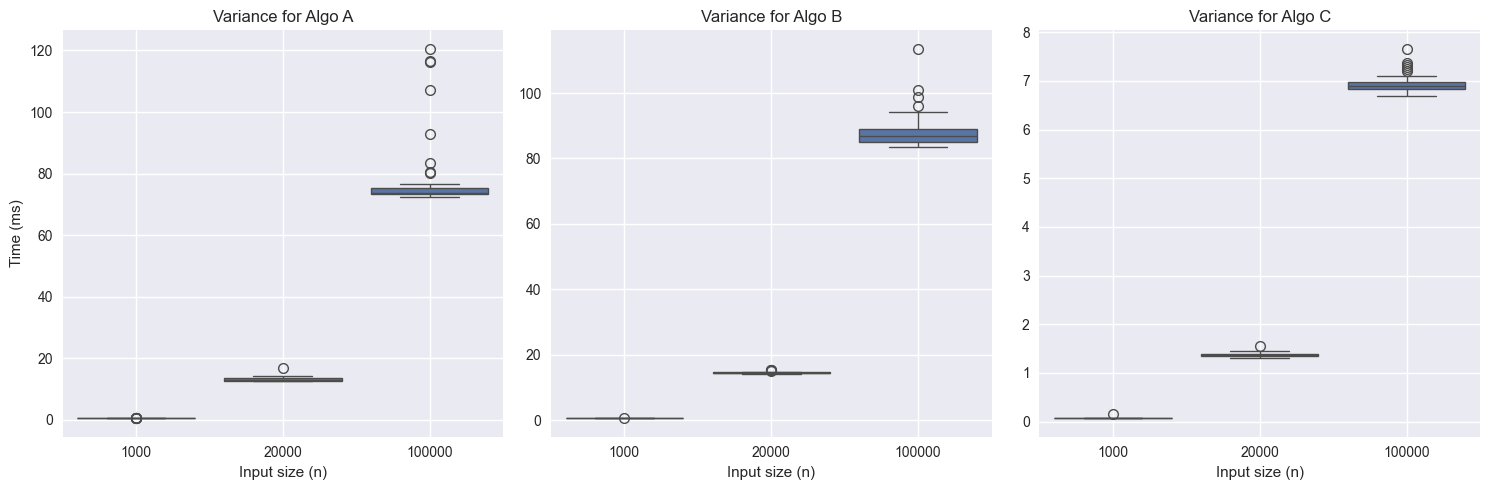

In [42]:
plt.figure(figsize=(15,5))

algos = ['A','B','C']

for i, algo in enumerate(algos, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(
        data=df_var[df_var["algo"] == algo],
        x="n",
        y="time_ms"
    )
    plt.title(f"Variance for Algo {algo}")
    plt.xlabel("Input size (n)")
    plt.ylabel("Time (ms)" if i == 1 else "")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Analisis & Diskusi

## 1. Performa Insertion Sort (Algo C)
Pada kasus near-sorted, Algo C menunjukkan performa sangat baik pada n kecil dan sedang.
Hal ini sesuai analisis teori bahwa Insertion Sort memiliki kompleksitas O(n + k),
di mana k = jumlah elemen yang tidak berada pada posisi final.

Karena distribusi Near-A hanya menggeser sebagian kecil elemen, k relatif kecil → runtime kecil.

## 2. Performa Merge Sort (Algo B)
MergeSort stabil di semua ukuran n dan semua seed.
Varian runtime sangat kecil, konsisten dengan sifat divide-and-conquer yang deterministik.

## 3. Performa QuickSort (Algo A)
QuickSort umumnya cepat, tetapi lebih variatif.
Pada instance near-sorted, pivot tengah dapat menghasilkan pembagian yang tidak seimbang.
Hal ini terlihat dari plot variansi — terdapat spread lebih besar dibanding MergeSort.

## 4. Scaling Behaviour
- Algo C → bagus untuk n kecil (near-sorted) dan mulai collape pada n besar (sesuai O(n^2))
- Algo A & B → sama-sama scaling O(n log n), dengan A cenderung lebih cepat tetapi kurang stabil.


In [43]:
try:
    from scipy.stats import ttest_rel

    for n in sorted(df['n'].unique()):
        a = df[(df['n']==n) & (df['algo']=='A')]['time_ms']
        b = df[(df['n']==n) & (df['algo']=='B')]['time_ms']
        if len(a)==len(b):
            t,p = ttest_rel(a,b)
            print(f"n={n}: t = {t:.3f}, p = {p:.4f}")
        else:
            print(f"n={n}: ukuran data tidak cocok, skip t-test")

except Exception as e:
    print("SciPy tidak tersedia. Skip uji statistik.", e)


n=1000: t = -3.467, p = 0.0741
n=5000: t = -4.020, p = 0.0567
n=20000: t = -5.684, p = 0.0296
n=100000: t = -1.230, p = 0.3438
n=500000: t = -6.013, p = 0.0266


In [44]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8")

LOG_PATH = Path("../results/instrument_logs")

def load_instrumented_logs():
    logs = []
    for file in LOG_PATH.glob("*.json"):
        with open(file, "r", encoding="utf-8") as f:
            obj = json.load(f)
        logs.append({
            "algo": obj["algo"],
            "instance_id": obj["instance_id"],
            "n": obj["n"],
            "log": obj["log"],
            "total_ms": obj["total_ms"]
        })
    return logs

instrumented_data = load_instrumented_logs()
print(f"Loaded {len(instrumented_data)} instrumented logs.")

Loaded 45 instrumented logs.


In [45]:
# list instance & algo
inst_ids = sorted(set(d['instance_id'] for d in instrumented_data))
algos = sorted(set(d['algo'] for d in instrumented_data))

print("Instances:", inst_ids)
print("Algorithms:", algos)

Instances: ['1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']
Algorithms: ['insertion', 'merge', 'quick']


In [46]:
for d in instrumented_data:
    print(f"algo={d['algo']}, instance_id={d['instance_id']}, n={d['n']}")

algo=insertion, instance_id=10, n=100000
algo=insertion, instance_id=11, n=100000
algo=insertion, instance_id=12, n=100000
algo=insertion, instance_id=13, n=500000
algo=insertion, instance_id=14, n=500000
algo=insertion, instance_id=15, n=500000
algo=insertion, instance_id=1, n=1000
algo=insertion, instance_id=2, n=1000
algo=insertion, instance_id=3, n=1000
algo=insertion, instance_id=4, n=5000
algo=insertion, instance_id=5, n=5000
algo=insertion, instance_id=6, n=5000
algo=insertion, instance_id=7, n=20000
algo=insertion, instance_id=8, n=20000
algo=insertion, instance_id=9, n=20000
algo=merge, instance_id=10, n=100000
algo=merge, instance_id=11, n=100000
algo=merge, instance_id=12, n=100000
algo=merge, instance_id=13, n=500000
algo=merge, instance_id=14, n=500000
algo=merge, instance_id=15, n=500000
algo=merge, instance_id=1, n=1000
algo=merge, instance_id=2, n=1000
algo=merge, instance_id=3, n=1000
algo=merge, instance_id=4, n=5000
algo=merge, instance_id=5, n=5000
algo=merge, insta

In [47]:
def pick_instance(n, error_level):
    """
    error_level:
        2  -> 0.02 (instance ke-1 dalam grup)
        5  -> 0.05 (instance ke-2 dalam grup)
        10 -> 0.10 (instance ke-3 dalam grup)
    """
    index = {2: 1, 5: 2, 10: 3}[error_level]

    # filter instance berdasarkan ukuran n
    candidates = sorted(
        [d for d in instrumented_data if d["n"] == n],
        key=lambda x: x["instance_id"]
    )

    # ambil instance_id yang tepat berdasarkan urutan error
    chosen = candidates[index - 1]["instance_id"]
    return chosen

In [48]:
def plot_instance(target_inst, title_suffix=""):
    plt.figure(figsize=(10,6))

    for algo in algos:
        d = next((x for x in instrumented_data 
                  if x["algo"] == algo and x["instance_id"] == target_inst), None)
        if d is None:
            continue

        xs = [e["ms"] for e in d["log"]]
        ys = [e["ops"] for e in d["log"]]
        plt.plot(xs, ys, label=f"{algo} (n={d['n']})")

    plt.xlabel("Time (ms)")
    plt.ylabel("Operations executed in millions")
    plt.title(f"OPS vs Time — Instance {target_inst} {title_suffix}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


=== VISUALISASI ERROR 2% ===
20k → 7
100k → 10
500k → 13


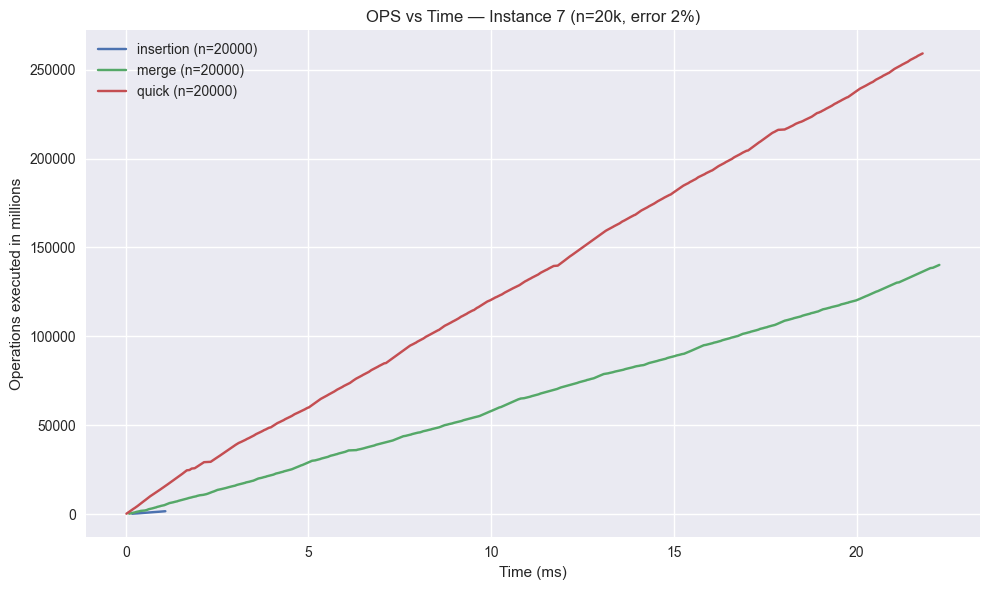

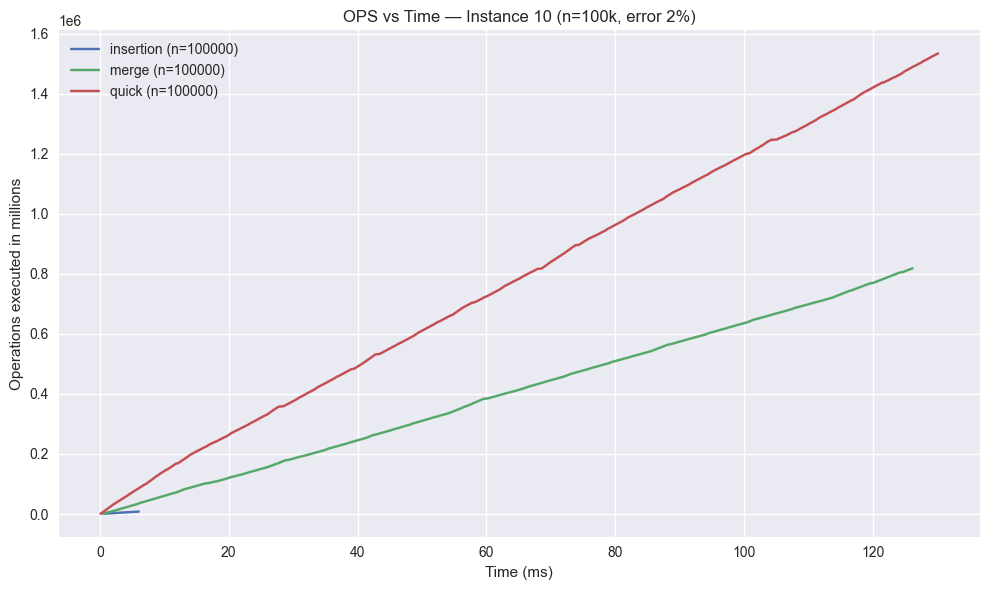

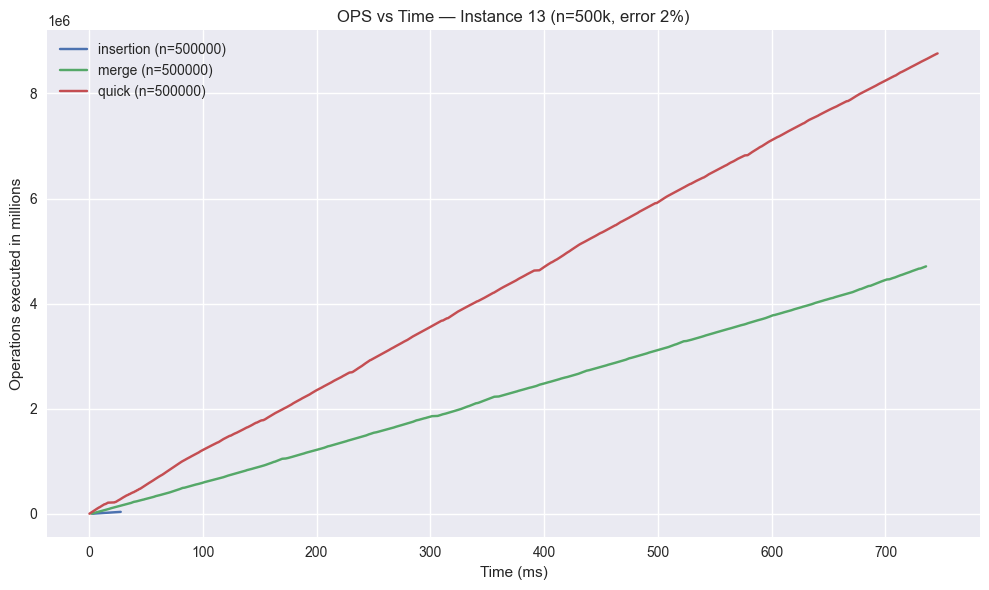

In [49]:
print("=== VISUALISASI ERROR 2% ===")

# instance_id untuk masing-masing n
inst_20k_2  = pick_instance(20000, 2)
inst_100k_2 = pick_instance(100000, 2)
inst_500k_2 = pick_instance(500000, 2)

print("20k →", inst_20k_2)
print("100k →", inst_100k_2)
print("500k →", inst_500k_2)

plot_instance(inst_20k_2,  "(n=20k, error 2%)")
plot_instance(inst_100k_2, "(n=100k, error 2%)")
plot_instance(inst_500k_2, "(n=500k, error 2%)")

=== VISUALISASI ERROR 5% ===
20k → 7
100k → 10
500k → 13


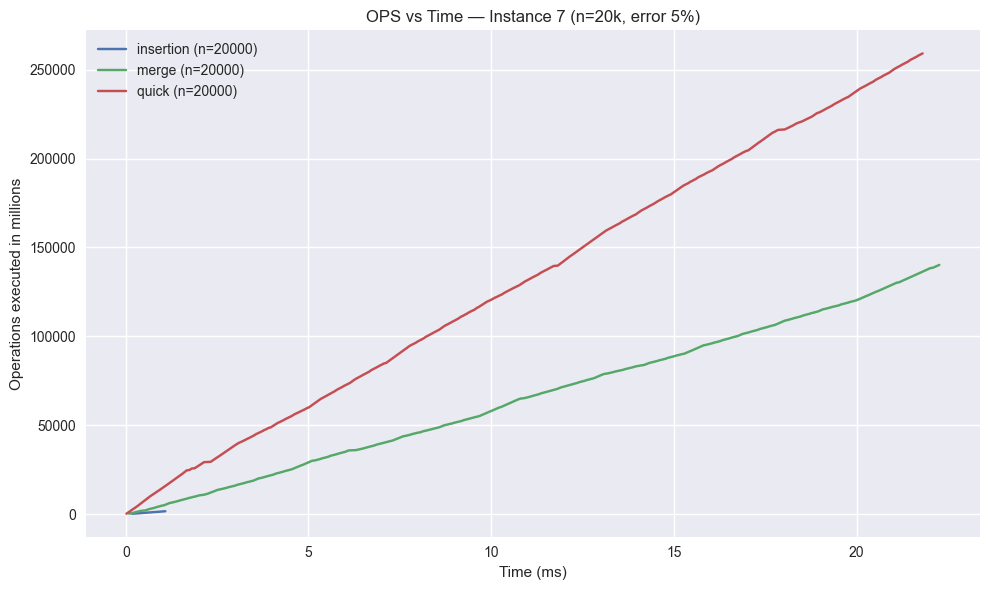

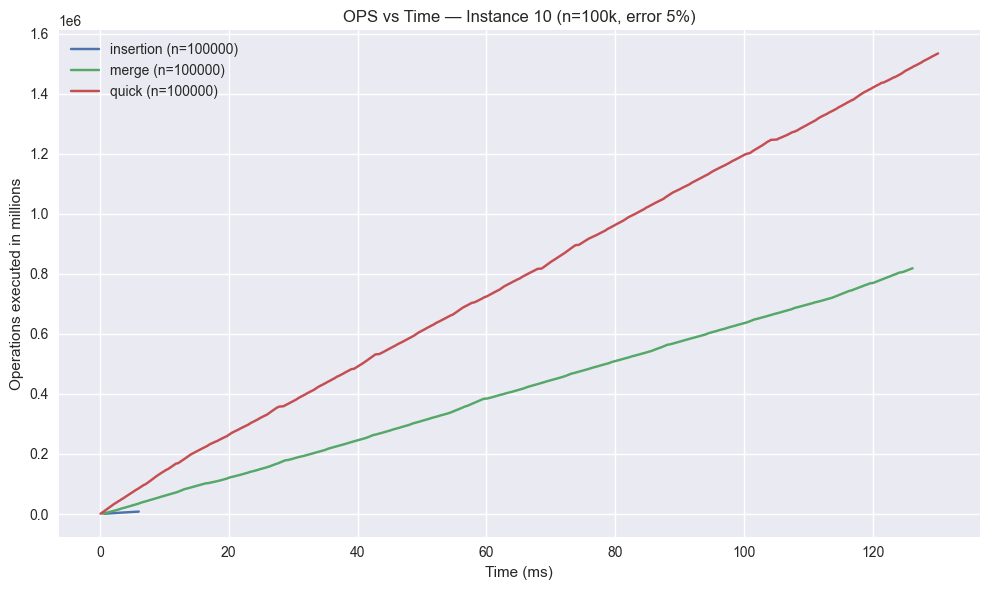

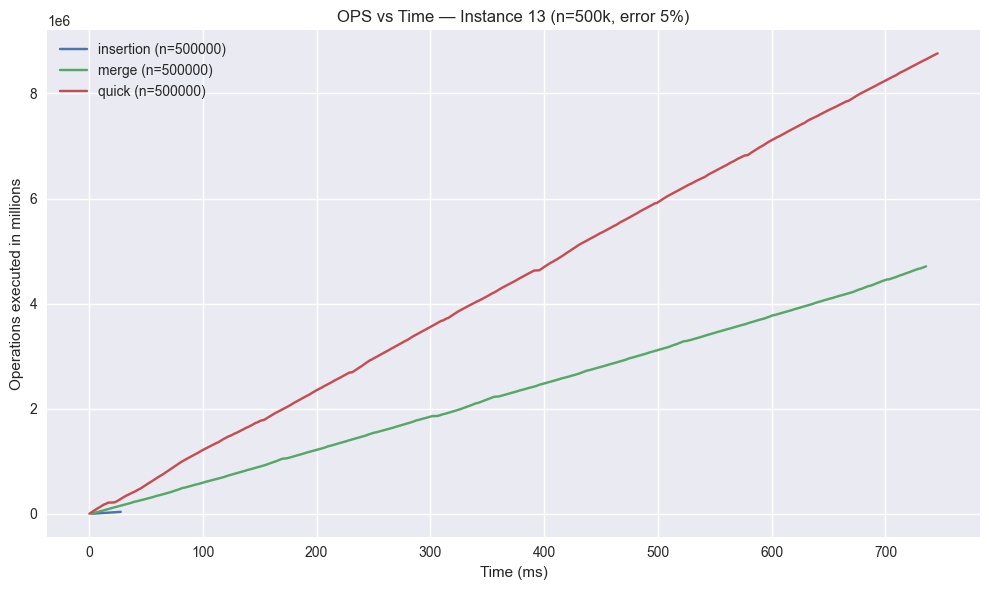

In [50]:
print("=== VISUALISASI ERROR 5% ===")

# instance_id untuk masing-masing n
inst_20k_5  = pick_instance(20000, 5)
inst_100k_5 = pick_instance(100000, 5)
inst_500k_5 = pick_instance(500000, 5)

print("20k →", inst_20k_5)
print("100k →", inst_100k_5)
print("500k →", inst_500k_5)

plot_instance(inst_20k_5,  "(n=20k, error 5%)")
plot_instance(inst_100k_5, "(n=100k, error 5%)")
plot_instance(inst_500k_5, "(n=500k, error 5%)")


=== VISUALISASI ERROR 10% ===
20k → 7
100k → 10
500k → 13


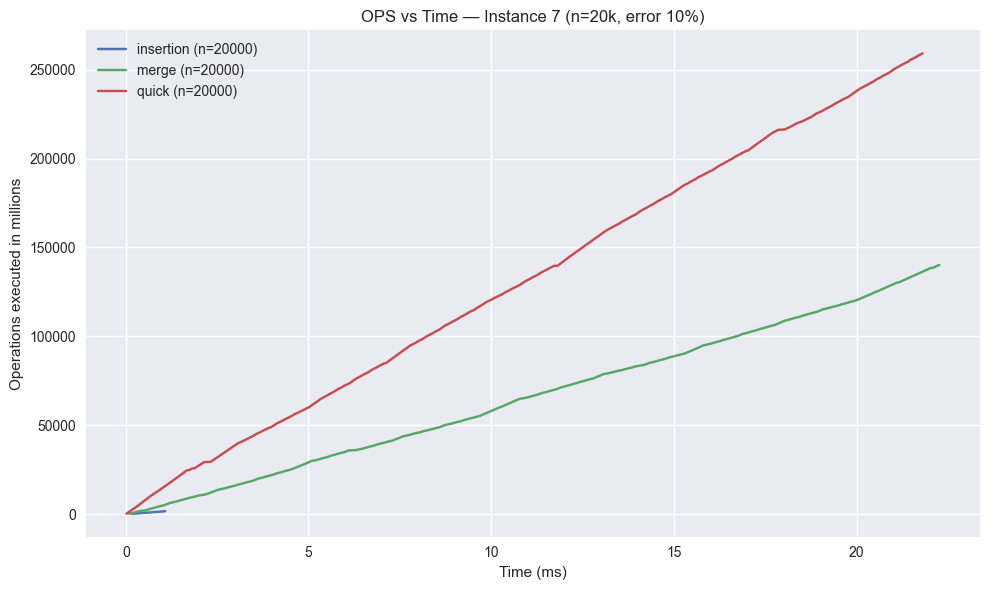

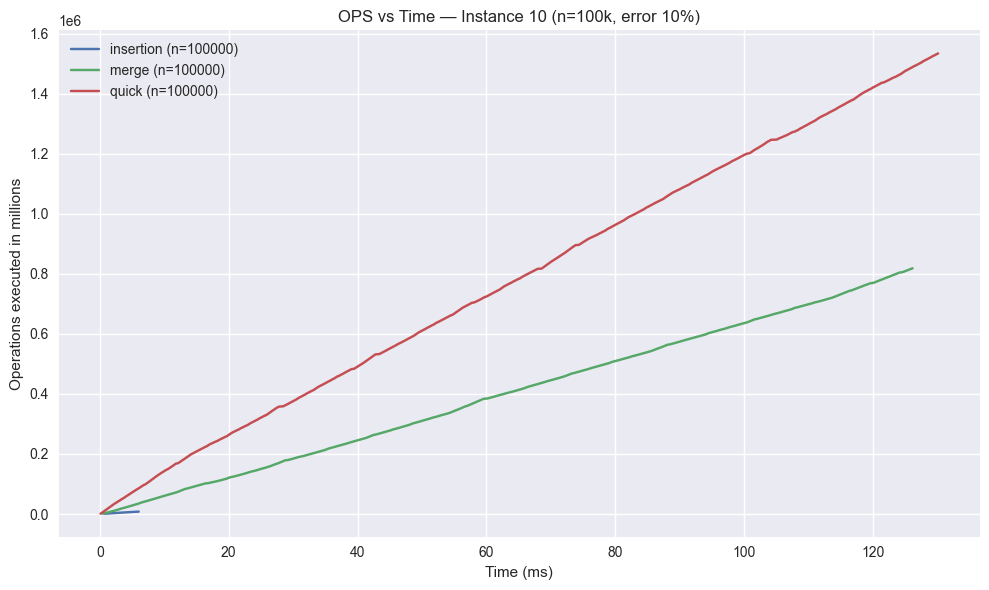

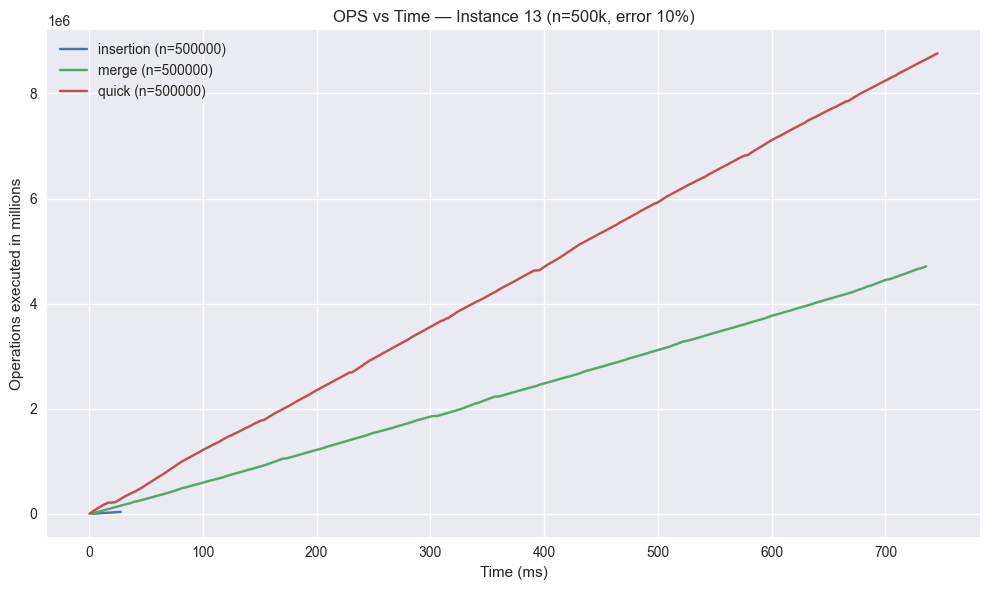

In [51]:
print("=== VISUALISASI ERROR 10% ===")

# Ambil instance_id berdasarkan n dan error 10%
inst_20k_10  = pick_instance(20000, 10)
inst_100k_10 = pick_instance(100000, 10)
inst_500k_10 = pick_instance(500000, 10)

print("20k →", inst_20k_10)
print("100k →", inst_100k_10)
print("500k →", inst_500k_10)

# Generate grafik
plot_instance(inst_20k_10,  "(n=20k, error 10%)")
plot_instance(inst_100k_10, "(n=100k, error 10%)")
plot_instance(inst_500k_10, "(n=500k, error 10%)")

In [52]:
import json
from pathlib import Path

LOG_DIR = Path("../results/instrument_logs")

instrumented_data = []

for f in LOG_DIR.glob("*.json"):
    with open(f, "r") as fp:
        instrumented_data.append(json.load(fp))

print("Loaded logs:", len(instrumented_data))

Loaded logs: 45


Loaded logs: 45
Instance IDs available: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

=== Plotting n=20000, instance_id=9 ===


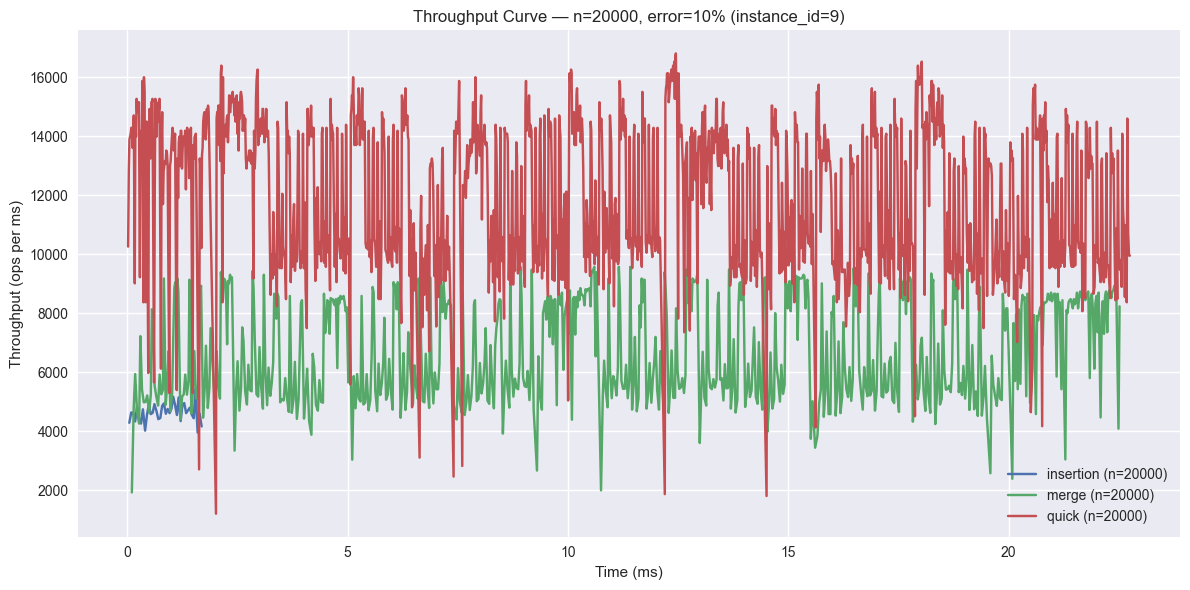


=== Plotting n=100000, instance_id=10 ===


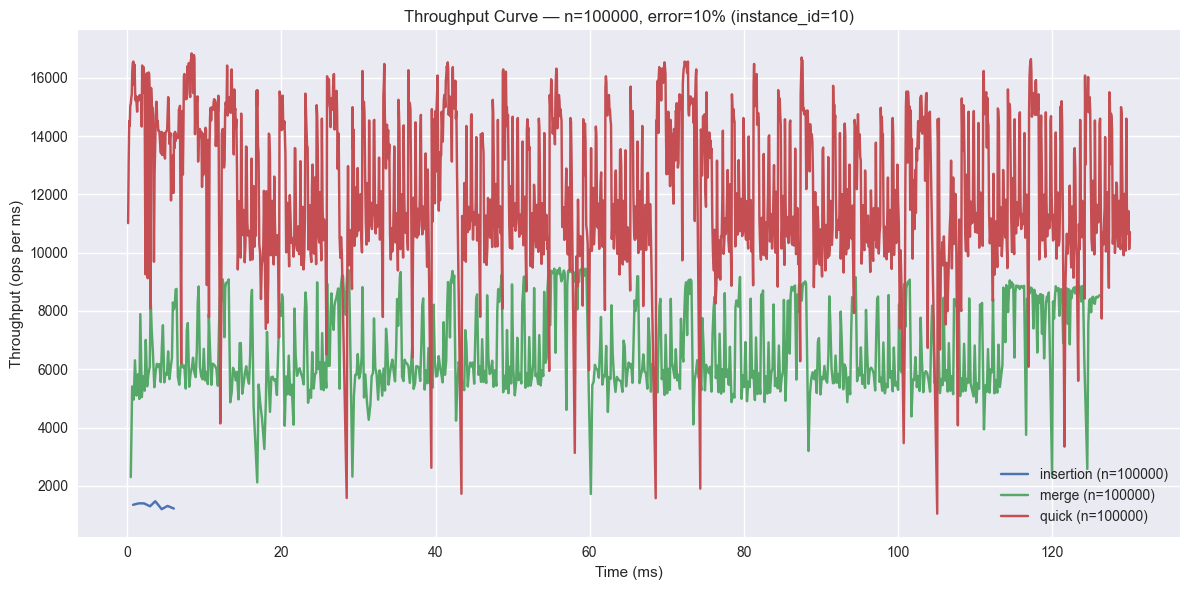


=== Plotting n=500000, instance_id=13 ===


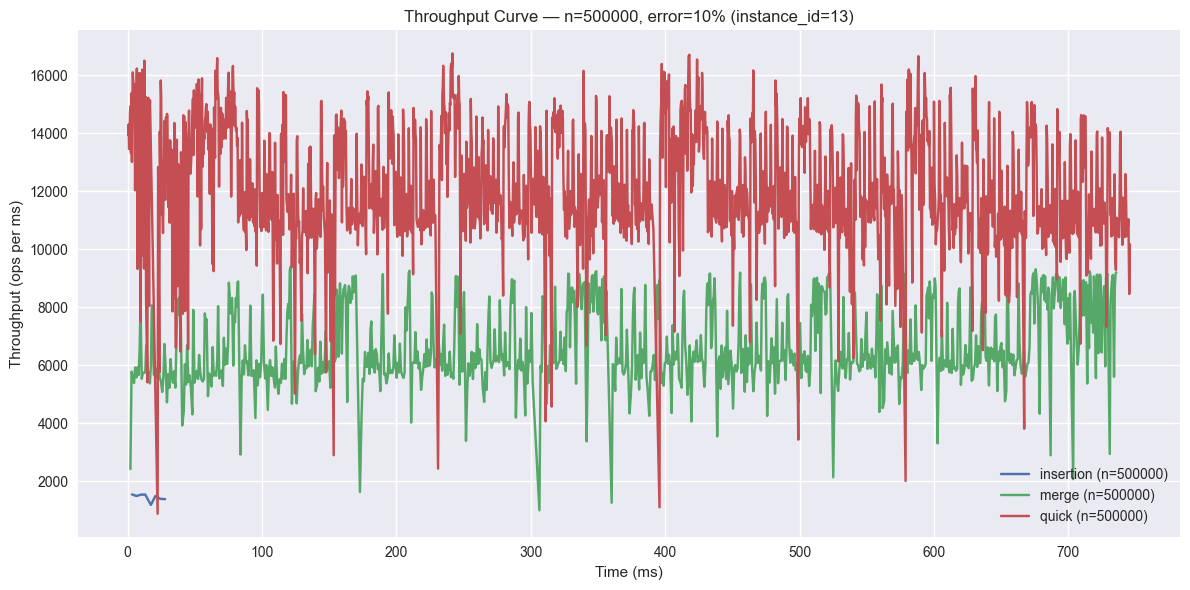

In [53]:
import json
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

# === Load Semua Log Instrumented ===
LOG_DIR = Path("../results/instrument_logs")

instrumented_data = []

for f in LOG_DIR.glob("*.json"):
    with open(f, "r") as fp:
        obj = json.load(fp)

        # FIX: instance_id harus integer
        obj["instance_id"] = int(obj["instance_id"])

        instrumented_data.append(obj)

print("Loaded logs:", len(instrumented_data))

# Cek semua instance_id unik
inst_ids = sorted({d["instance_id"] for d in instrumented_data})
print("Instance IDs available:", inst_ids)


# === Helper: Compute Throughput (ops per ms) ===
def compute_throughput(log):
    through = []
    prev_ops = 0
    prev_ms = 0

    for entry in log:
        ops = entry["ops"]
        ms = entry["ms"]

        if ms - prev_ms > 0:
            tput = (ops - prev_ops) / (ms - prev_ms)
            through.append((ms, tput))

        prev_ops = ops
        prev_ms = ms

    return through


# === Mapping untuk error = 10% ===
# Final mapping berdasarkan ID yang kamu print sebelumnya
error10_instances = {
    20000: 9,       # insertion/merge/quick lengkap
    100000: 10,     # insertion/merge/quick lengkap
    500000: 13      # insertion/merge/quick lengkap
}

algos = ["insertion", "merge", "quick"]


# === Plot throughput untuk n tertentu ===
def plot_throughput_for_n(n):
    if n not in error10_instances:
        print(f"❌ Tidak ada mapping instance untuk n={n}")
        return

    target_inst = error10_instances[n]

    print(f"\n=== Plotting n={n}, instance_id={target_inst} ===")

    plt.figure(figsize=(12,6))

    found_any = False

    for algo in algos:
        d = next(
            (x for x in instrumented_data 
             if x["algo"] == algo and x["instance_id"] == target_inst),
            None
        )

        if d is None:
            print(f"(skip) Algo={algo} tidak ada datanya untuk id={target_inst}")
            continue

        found_any = True
        t_data = compute_throughput(d["log"])

        xs = [x for x,_ in t_data]
        ys = [y for _,y in t_data]

        plt.plot(xs, ys, label=f"{algo} (n={n})")

    if not found_any:
        print("❌ Tidak ada log yang cocok — plot kosong.")
        return

    plt.xlabel("Time (ms)")
    plt.ylabel("Throughput (ops per ms)")
    plt.title(f"Throughput Curve — n={n}, error=10% (instance_id={target_inst})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# === Generate 3 plot sesuai permintaan ===
plot_throughput_for_n(20000)
plot_throughput_for_n(100000)
plot_throughput_for_n(500000)


In [54]:
ALGOS = {"A": algo_A, "B": algo_B, "C": algo_C}

def get_meta(inst: dict, inst_path: Path):
    arr = inst.get("array", [])
    n = inst.get("n", len(arr))
    error = inst.get("error", inst.get("error_rate", inst.get("eps", None)))
    instance_id = inst.get("instance_id", inst_path.stem)
    project = inst.get("project", "sorting")
    return instance_id, n, error, project

def measure_instance(inst_path: Path, algo_key: str):
    inst = json.loads(inst_path.read_text(encoding="utf-8"))
    instance_id, n, error, project = get_meta(inst, inst_path)

    gc.collect()

    tracemalloc.start()
    tracemalloc.reset_peak()

    t0 = time.perf_counter()
    out = ALGOS[algo_key](inst, project)
    time_ms = (time.perf_counter() - t0) * 1000.0

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    gap = evaluate(inst, out, project)
    peak_mb = peak / (1024 * 1024)

    return {
        "instance": inst_path.name,
        "instance_id": instance_id,
        "n": int(n),
        "error": error,
        "algo": algo_key,
        "time_ms": time_ms,
        "peak_mb": peak_mb,
        "gap": gap
    }


In [55]:
TRIALS = 10
ALGOS_TO_RUN = ["A", "B", "C"]

instances = sorted(DATA_DIR.glob("*.json"))
print("Found instances:", len(instances))

rows = []
for inst_path, algo_key, t in product(instances, ALGOS_TO_RUN, range(1, TRIALS+1)):
    r = measure_instance(inst_path, algo_key)
    r["trial"] = t
    rows.append(r)

df_mem = pd.DataFrame(rows)
out_path = RESULTS_DIR / "memory_results.csv"
df_mem.to_csv(out_path, index=False)
out_path


Found instances: 15


WindowsPath('D:/projects/DAA/daa-sorting-benchmark/results/memory_results.csv')

In [56]:
df_mem = pd.read_csv(RESULTS_DIR / "memory_results.csv")

# Summary table (median is robust vs outliers)
summary = (df_mem
           .groupby(["n", "error", "algo"], as_index=False)
           .agg(time_ms_med=("time_ms", "median"),
                peak_mb_med=("peak_mb", "median"),
                gap_max=("gap", "max")))
summary.head()

,n,error,algo,time_ms_med,peak_mb_med,gap_max
0,1000,0.02,A,4.63310,0.034019,0.0
1,1000,0.02,B,7.01345,0.028252,0.0
2,1000,0.02,C,1.77090,0.007839,0.0
3,1000,0.05,A,4.73900,0.033913,0.0
4,1000,0.05,B,6.70555,0.028252,0.0


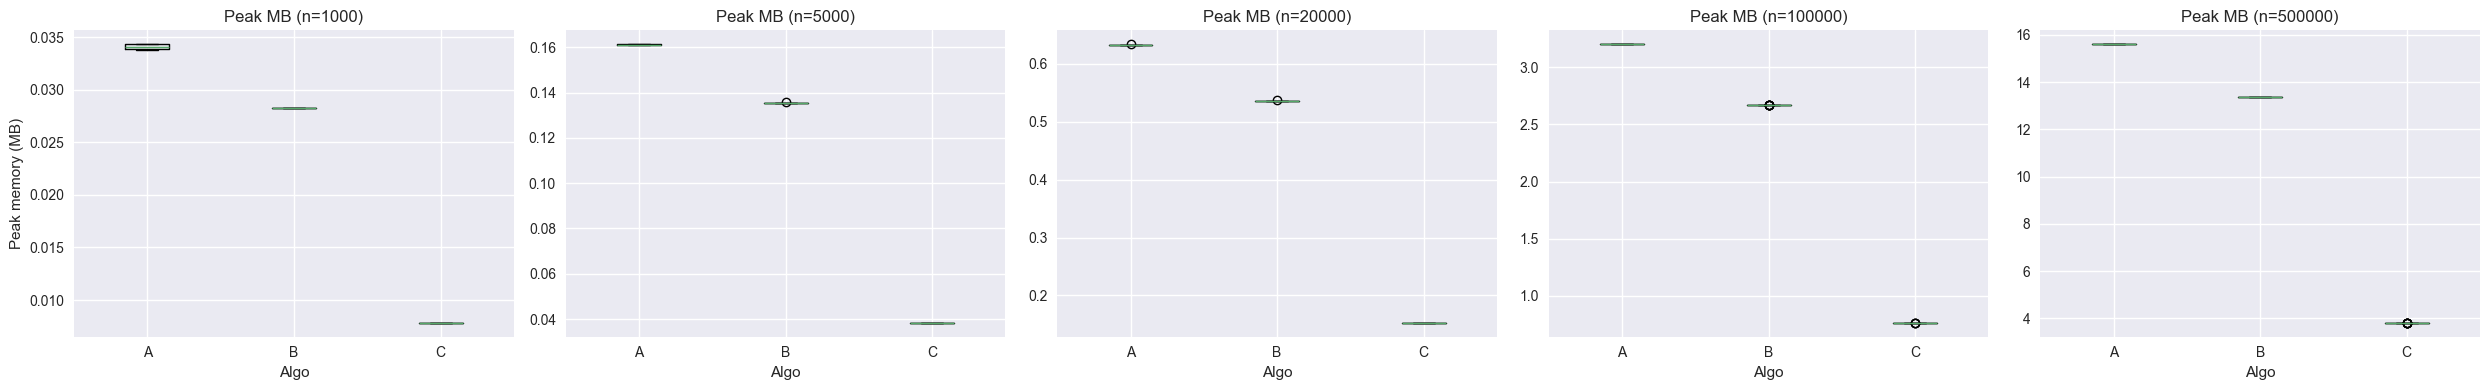

In [65]:
ns = sorted(df_mem["n"].unique())
fig, axes = plt.subplots(1, len(ns), figsize=(5*len(ns), 4), sharey=False)

if len(ns) == 1:
    axes = [axes]

for ax, nval in zip(axes, ns):
    sub = df_mem[df_mem["n"] == nval]
    data = [sub[sub["algo"] == a]["peak_mb"].values for a in ["A","B","C"]]
    ax.boxplot(data, tick_labels=["A","B","C"])
    ax.set_title(f"Peak MB (n={nval})")
    ax.set_xlabel("Algo")
    ax.grid(True)

axes[0].set_ylabel("Peak memory (MB)")
plt.tight_layout()
plt.show()


In [58]:
tmp = summary.copy()
tmp["nlogn"] = tmp["n"] * np.log2(tmp["n"])
tmp["mb_over_n"] = tmp["peak_mb_med"] / tmp["n"]
tmp["mb_over_nlogn"] = tmp["peak_mb_med"] / tmp["nlogn"]
tmp["mb_over_n2"] = tmp["peak_mb_med"] / (tmp["n"]**2)
tmp.sort_values(["algo","n"])[["algo","n","peak_mb_med","mb_over_n","mb_over_nlogn","mb_over_n2"]]

,algo,n,peak_mb_med,mb_over_n,mb_over_nlogn,mb_over_n2
0,A,1000,0.034019,0.000034,3.413627e-06,3.401947e-08
3,A,1000,0.033913,0.000034,3.402909e-06,3.391266e-08
6,A,1000,0.034317,0.000034,3.443484e-06,3.431702e-08
9,A,5000,0.161087,0.000032,2.621921e-06,6.443481e-09
12,A,5000,0.161011,0.000032,2.620679e-06,6.440430e-09
15,A,5000,0.161331,0.000032,2.625894e-06,6.453247e-09
18,A,20000,0.632507,0.000032,2.213466e-06,1.581268e-09
21,A,20000,0.632866,0.000032,2.214721e-06,1.582165e-09
24,A,20000,0.632812,0.000032,2.214534e-06,1.582031e-09
27,A,100000,3.201691,0.000032,1.927610e-06,3.201691e-10


In [ ]:
df_run = pd.read_csv(RESULTS_DIR / "run_results.csv")
df_mem = pd.read_csv(RESULTS_DIR / "memory_results.csv")

df_run.columns = [c.strip().lower() for c in df_run.columns]
df_mem.columns = [c.strip().lower() for c in df_mem.columns]

print("run cols:", df_run.columns.tolist())
print("mem cols:", df_mem.columns.tolist())


run cols: ['instance', 'n', 'error', 'algo', 'time_ms', 'gap']
mem cols: ['instance', 'instance_id', 'n', 'error', 'algo', 'time_ms', 'peak_mb', 'gap', 'trial']


In [60]:
mem_summary = (
    df_mem
    .groupby(["instance", "algo"], as_index=False)
    .agg(
        peak_mb_med=("peak_mb", "median"),
        peak_mb_mean=("peak_mb", "mean"),
        peak_mb_std=("peak_mb", "std"),
        time_ms_mem_med=("time_ms", "median"),
        trials=("trial", "count"),
        gap_max_mem=("gap", "max"),
    )
)
mem_summary.head()


,instance,algo,peak_mb_med,peak_mb_mean,peak_mb_std,time_ms_mem_med,trials,gap_max_mem
0,sorting_near_sorted_1.json,A,0.034019,0.033990,0.000092,4.63310,10,0.0
1,sorting_near_sorted_1.json,B,0.028252,0.028252,0.000000,7.01345,10,0.0
2,sorting_near_sorted_1.json,C,0.007839,0.007839,0.000000,1.77090,10,0.0
3,sorting_near_sorted_10.json,A,3.201691,3.201691,0.000000,580.94965,10,0.0
4,sorting_near_sorted_10.json,B,2.672585,2.672797,0.000447,1707.68815,10,0.0


In [ ]:
df_master = df_run.merge(mem_summary, on=["instance", "algo"], how="left")

for col in ["n", "time_ms", "gap", "peak_mb_med", "peak_mb_mean", "peak_mb_std"]:
    if col in df_master.columns:
        df_master[col] = pd.to_numeric(df_master[col], errors="coerce")

df_master.head()


,instance,n,error,algo,time_ms,gap,peak_mb_med,peak_mb_mean,peak_mb_std,time_ms_mem_med,trials,gap_max_mem
0,sorting_near_sorted_1.json,1000,0.02,A,0.50,0.0,0.034019,0.033990,0.000092,4.63310,10,0.0
1,sorting_near_sorted_1.json,1000,0.02,B,0.63,0.0,0.028252,0.028252,0.000000,7.01345,10,0.0
2,sorting_near_sorted_1.json,1000,0.02,C,0.06,0.0,0.007839,0.007839,0.000000,1.77090,10,0.0
3,sorting_near_sorted_10.json,100000,0.02,A,73.33,0.0,3.201691,3.201691,0.000000,580.94965,10,0.0
4,sorting_near_sorted_10.json,100000,0.02,B,84.87,0.0,2.672585,2.672797,0.000447,1707.68815,10,0.0


In [62]:
out_path = RESULTS_DIR / "master_results.csv"
df_master.to_csv(out_path, index=False)
out_path


WindowsPath('D:/projects/DAA/daa-sorting-benchmark/results/master_results.csv')

In [66]:
df_run = pd.read_csv("../results/run_results.csv")
df_mem = pd.read_csv("../results/memory_results.csv")

time_stats = (df_run.groupby(["algo","n"])["time_ms"]
              .agg(time_mean="mean", time_sd="std").reset_index())

gap_stats  = (df_run.groupby(["algo","n"])["gap"]
              .agg(gap_mean="mean", gap_sd="std").reset_index())

mem_stats  = (df_mem.groupby(["algo","n"])["peak_mb"]
              .agg(mem_mean="mean", mem_sd="std").reset_index())

tbl = (time_stats.merge(mem_stats, on=["algo","n"], how="left")
                 .merge(gap_stats,  on=["algo","n"], how="left"))

def pm(mean, sd, digits=2):
    if pd.isna(sd):
        return f"{mean:.{digits}f}"
    return f"{mean:.{digits}f} $\\pm$ {sd:.{digits}f}"

tbl["Waktu (ms)"]  = tbl.apply(lambda r: pm(r["time_mean"], r["time_sd"], 2), axis=1)
tbl["Memori (MB)"] = tbl.apply(lambda r: pm(r["mem_mean"],  r["mem_sd"],  2), axis=1)
tbl["Gap (\\%)"]   = tbl.apply(lambda r: pm(r["gap_mean"],  r["gap_sd"],  2), axis=1)

name_map = {
    "A": "Quick Sort",
    "B": "Merge Sort",
    "C": "Insertion Sort",
}

tbl["Algoritma"] = tbl["algo"].map(name_map).fillna(tbl["algo"])

tbl_final = (tbl.sort_values(["Algoritma","n"])
               [["Algoritma","n","Waktu (ms)","Memori (MB)","Gap (\\%)"]])

latex_str = tbl_final.to_latex(
    index=False,
    escape=False,
    caption="Rangkuman performa (rata-rata $\\pm$ sd) pada beberapa ukuran $n$.",
    label="tab:performa",
    column_format="lrrrr"
)

out_path = "../results/table1_performa.tex"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_str)

print("Saved:", out_path)


Saved: ../results/table1_performa.tex
